In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Dimensión del array phi: (50, 50, 50)
Rango de valores de φ: [0.0000, 0.0550]


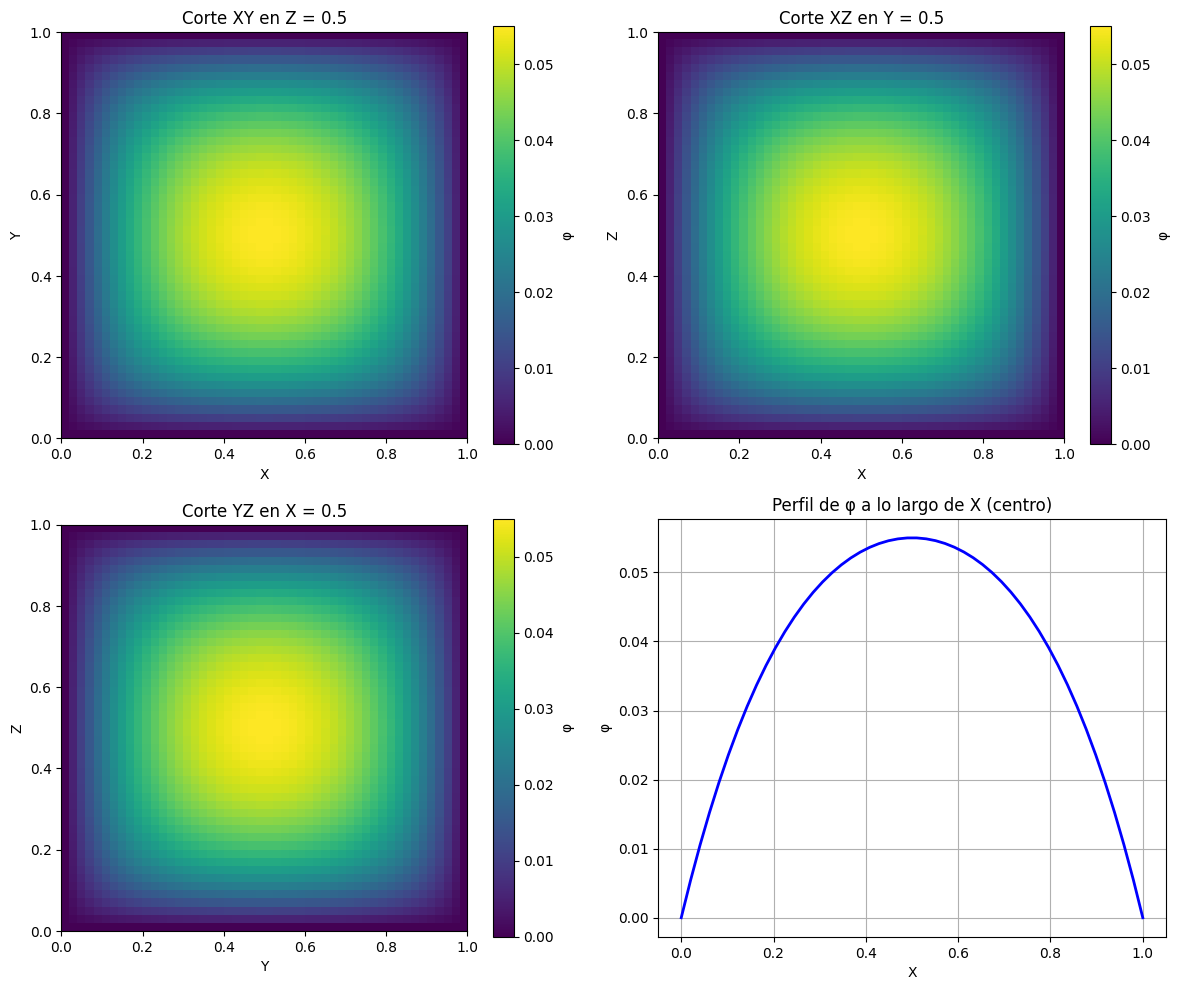

Los datos tienen muy poca variación para visualización 3D


In [11]:

def read_vtk_corrected(filename):
    """Lee correctamente el archivo VTK generado por tu código C++"""
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    # Extraer dimensiones
    dims = None
    points_start = None
    data_start = None
    
    for i, line in enumerate(lines):
        if "DIMENSIONS" in line:
            dims = list(map(int, line.split()[1:4]))
        elif "POINTS" in line:
            points_start = i + 1
        elif "SCALARS phi" in line:
            data_start = i + 2
            break
    
    if dims is None or data_start is None:
        raise ValueError("Formato VTK incorrecto")
    
    nx, ny, nz = dims
    
    # Leer datos de phi
    phi_data = []
    for line in lines[data_start:data_start + nx*ny*nz]:
        try:
            phi_data.append(float(line.strip()))
        except:
            continue
    
    # Reorganizar en el orden correcto (x, y, z)
    phi = np.array(phi_data).reshape((nz, ny, nx), order='F').transpose(2, 1, 0)
    
    return phi, nx, ny, nz

# Cargar datos corregidos
phi, nx, ny, nz = read_vtk_corrected("poisson3d.vtk")

print(f"Dimensión del array phi: {phi.shape}")
print(f"Rango de valores de φ: [{np.min(phi):.4f}, {np.max(phi):.4f}]")

# Visualización CORRECTA con cortes 2D
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Corte central XY
im1 = axes[0,0].imshow(phi[:, :, nz//2], origin='lower', cmap='viridis', 
                      extent=[0, 1, 0, 1])
axes[0,0].set_title(f'Corte XY en Z = 0.5')
axes[0,0].set_xlabel('X')
axes[0,0].set_ylabel('Y')
plt.colorbar(im1, ax=axes[0,0], label='φ')

# Corte central XZ
im2 = axes[0,1].imshow(phi[:, ny//2, :], origin='lower', cmap='viridis',
                      extent=[0, 1, 0, 1])
axes[0,1].set_title(f'Corte XZ en Y = 0.5')
axes[0,1].set_xlabel('X')
axes[0,1].set_ylabel('Z')
plt.colorbar(im2, ax=axes[0,1], label='φ')

# Corte central YZ
im3 = axes[1,0].imshow(phi[nx//2, :, :], origin='lower', cmap='viridis',
                      extent=[0, 1, 0, 1])
axes[1,0].set_title(f'Corte YZ en X = 0.5')
axes[1,0].set_xlabel('Y')
axes[1,0].set_ylabel('Z')
plt.colorbar(im3, ax=axes[1,0], label='φ')

# Perfil lineal a lo largo de X en el centro
x = np.linspace(0, 1, nx)
axes[1,1].plot(x, phi[:, ny//2, nz//2], 'b-', linewidth=2)
axes[1,1].set_xlabel('X')
axes[1,1].set_ylabel('φ')
axes[1,1].set_title('Perfil de φ a lo largo de X (centro)')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

# Visualización 3D de isosuperficie (solo si los datos son buenos)
if np.max(np.abs(phi)) > 0.1:  # Solo si hay variación significativa
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Crear isosuperficie
    X, Y, Z = np.mgrid[0:1:nx*1j, 0:1:ny*1j, 0:1:nz*1j]
    
    # Usar solo cada 2do punto para eficiencia
    step = max(1, nx // 20)
    mask = np.abs(phi[::step, ::step, ::step]) > 0.1 * np.max(np.abs(phi))
    
    x_idx, y_idx, z_idx = np.where(mask)
    ax.scatter(X[::step, ::step, ::step][mask], 
               Y[::step, ::step, ::step][mask], 
               Z[::step, ::step, ::step][mask],
               c=phi[::step, ::step, ::step][mask], 
               cmap='viridis', alpha=0.6, s=20)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Distribución 3D del Potencial φ')
    plt.show()
else:
    print("Los datos tienen muy poca variación para visualización 3D")

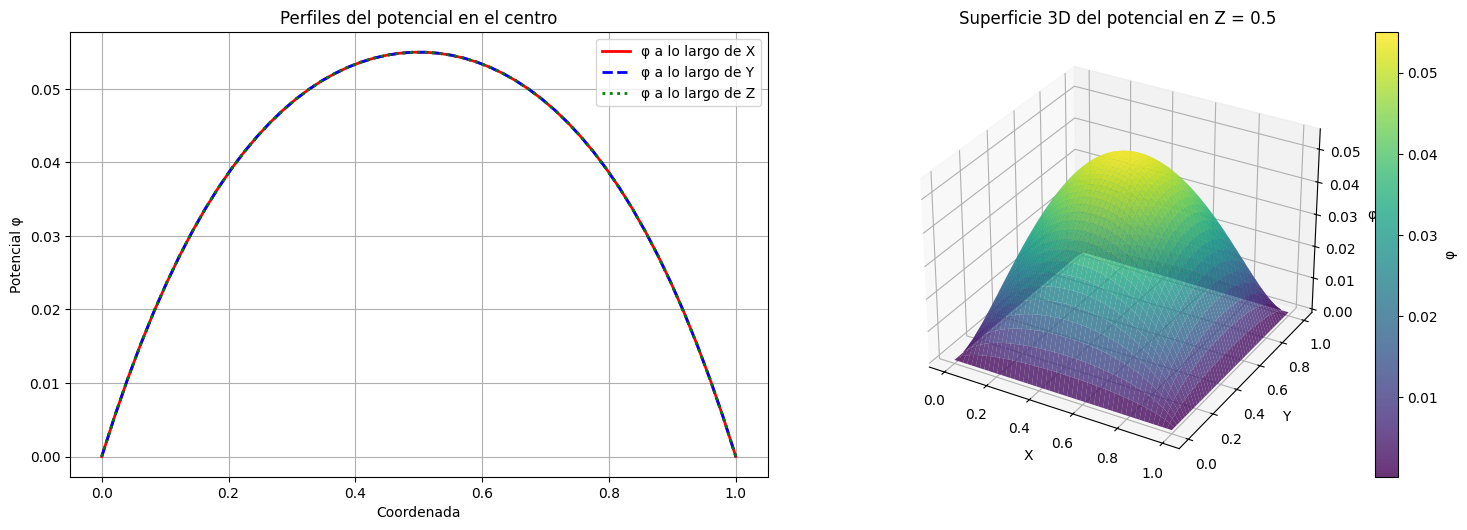


=== ANÁLISIS CUANTITATIVO ===
Valor máximo teórico esperado: ≈0.062500 (para dominio [0,1]³)
Valor máximo obtenido: 0.054989
Error relativo: 12.02%


In [ ]:
# Visualización profesional
fig = plt.figure(figsize=(15, 10))



# 2. Perfil 1D a través del centro
ax2 = fig.add_subplot(221)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
z = np.linspace(0, 1, nz)

ax2.plot(x, phi[:, ny//2, nz//2], 'r-', linewidth=2, label='φ a lo largo de X')
ax2.plot(y, phi[nx//2, :, nz//2], 'b--', linewidth=2, label='φ a lo largo de Y')
ax2.plot(z, phi[nx//2, ny//2, :], 'g:', linewidth=2, label='φ a lo largo de Z')
ax2.set_xlabel('Coordenada')
ax2.set_ylabel('Potencial φ')
ax2.set_title('Perfiles del potencial en el centro')
ax2.legend()
ax2.grid(True)

# 3. Superficie 3D del corte central
ax3 = fig.add_subplot(22, projection='3d')
X, Y = np.meshgrid(x, y, indexing='ij')
Z_plot = phi[:, :, nz//2]
surf = ax3.plot_surface(X, Y, Z_plot, cmap='viridis', alpha=0.8)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('φ')
ax3.set_title('Superficie 3D del potencial en Z = 0.5')
fig.colorbar(surf, ax=ax3, label='φ')



plt.tight_layout()
plt.show()

# Análisis cuantitativo
print("\n=== ANÁLISIS CUANTITATIVO ===")
print(f"Valor máximo teórico esperado: ≈{1/16:.6f} (para dominio [0,1]³)")
print(f"Valor máximo obtenido: {np.max(phi):.6f}")
print(f"Error relativo: {abs(np.max(phi) - 1/16)/(1/16)*100:.2f}%")